In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-latest-small'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,dfflagtrain,dfflagvalid,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [4]:
df.shape

(100836, 19)

In [5]:
df.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,seqNum,maxSeqNum,time_dstype,user_idx,movie_idx,dstype_random_train,dstype_time_train,dstype_random_valid,dstype_time_valid
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,1,232,train,1,1,1,1,0,0
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,2,232,train,1,2,1,1,0,0
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,3,232,train,1,3,1,1,0,0
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,4,232,train,1,4,1,1,0,0
4,1,2018,5.0,2000-07-30 18:08:43,Bambi (1942),Animation|Children|Drama,34492,3170.0,NaN,test,5,232,train,1,5,0,1,1,0


In [6]:
df_train=df.loc[df['random_dstype']=='train']
df_valid=df.loc[df['random_dstype']!='train']

In [7]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,seqNum,maxSeqNum,time_dstype,user_idx,movie_idx,dstype_random_train,dstype_time_train,dstype_random_valid,dstype_time_valid
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,1,232,train,1,1,1,1,0,0
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,2,232,train,1,2,1,1,0,0
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,3,232,train,1,3,1,1,0,0
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,4,232,train,1,4,1,1,0,0
5,1,3578,5.0,2000-07-30 18:11:08,Gladiator (2000),Action|Adventure|Drama,172495,98.0,NaN,train,6,232,train,1,6,1,1,0,0


### Add the autoencoder features

In [8]:
import pickle

In [9]:
[df_train_user_autoenc,df_valid_user_autoenc,user_mtx_1_weights,user_mtx_2_weights]=\
    pickle.load(open(f'{DATAPATH}/inter/user_autoenc_weights.pkl','rb'))

In [10]:
[df_train_item_autoenc, df_valid_item_autoenc,item_mtx_1_weights,item_mtx_2_weights]=\
    pickle.load(open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','rb'))

In [11]:
df_train_user_autoenc.shape, type(df_train_user_autoenc),df_train_user_autoenc.head()

((610, 4),
 pandas.core.frame.DataFrame,
    userId  user_autoenc0  user_autoenc1  user_autoenc2
 0       1      -0.479369       0.641243       1.155024
 1       2       0.654193       2.906792      -2.338487
 2       3      -1.727728       1.539072       2.343679
 3       4      -0.361162      -0.812232       0.772347
 4       5      -0.564455      -0.322158       1.608243)

In [12]:
df_train_item_autoenc.shape, type(df_train_item_autoenc),df_train_item_autoenc.head()

((9724, 11),
 pandas.core.frame.DataFrame,
    movieId  item_autoenc0  item_autoenc1  item_autoenc2  item_autoenc3  \
 0        1       6.827414      -5.010858     -14.244909      -6.124948   
 1        2     -22.056328      -3.937419     -10.244719      -7.376902   
 2        3     -23.581443      -4.855818      -9.132980      -7.604265   
 3        4     -16.496840      -3.710789      -8.657591      -5.454689   
 4        5     -30.099342      -4.454163      -8.632300      -7.230441   
 
    item_autoenc4  item_autoenc5  item_autoenc6  item_autoenc7  item_autoenc8  \
 0      -7.750169      -9.440641     -12.444607      -9.455640       9.730766   
 1      -8.613933      -7.666921      -9.932867       6.505567       6.030026   
 2     -10.740304      -7.919054     -11.727813       8.207041       8.586024   
 3      -8.051945      -6.644208      -7.937984       6.020888       7.733612   
 4     -11.383443      -6.582665     -10.532912      12.771882       8.376647   
 
    item_autoenc9

In [13]:
df_train.shape

(90752, 19)

In [14]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,seqNum,maxSeqNum,time_dstype,user_idx,movie_idx,dstype_random_train,dstype_time_train,dstype_random_valid,dstype_time_valid
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,1,232,train,1,1,1,1,0,0
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,2,232,train,1,2,1,1,0,0
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,3,232,train,1,3,1,1,0,0
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,4,232,train,1,4,1,1,0,0
5,1,3578,5.0,2000-07-30 18:11:08,Gladiator (2000),Action|Adventure|Drama,172495,98.0,NaN,train,6,232,train,1,6,1,1,0,0


In [15]:
df_train=pd.merge(df_train,df_train_item_autoenc,on='movieId',how='left')

In [16]:
df_train.shape

(90752, 29)

In [17]:
print(df_valid.shape)
df_valid=pd.merge(df_valid,df_valid_item_autoenc,on='movieId',how='left')
df_valid.shape

(10084, 19)


(10084, 29)

In [18]:
df_valid.shape

(10084, 29)

In [19]:
print(df_valid.shape)
df_valid=pd.merge(df_valid,df_valid_user_autoenc,on='userId',how='left')
df_valid.shape

(10084, 29)


(10084, 32)

In [20]:
print(df_train.shape)
df_train=pd.merge(df_train,df_train_user_autoenc,on='userId',how='left')
df_train.shape

(90752, 29)


(90752, 32)

In [21]:
df_train.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId', 'tag', 'random_dstype', 'seqNum', 'maxSeqNum', 'time_dstype',
       'user_idx', 'movie_idx', 'dstype_random_train', 'dstype_time_train',
       'dstype_random_valid', 'dstype_time_valid', 'item_autoenc0',
       'item_autoenc1', 'item_autoenc2', 'item_autoenc3', 'item_autoenc4',
       'item_autoenc5', 'item_autoenc6', 'item_autoenc7', 'item_autoenc8',
       'item_autoenc9', 'user_autoenc0', 'user_autoenc1', 'user_autoenc2'],
      dtype='object')

In [22]:
autoenc_cols=df_train.columns[df_train.columns.str.contains('autoenc')]

In [23]:
autoenc_cols=autoenc_cols.tolist()

In [24]:
autoenc_cols

['item_autoenc0',
 'item_autoenc1',
 'item_autoenc2',
 'item_autoenc3',
 'item_autoenc4',
 'item_autoenc5',
 'item_autoenc6',
 'item_autoenc7',
 'item_autoenc8',
 'item_autoenc9',
 'user_autoenc0',
 'user_autoenc1',
 'user_autoenc2']

In [25]:
df_train.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,tag,random_dstype,...,item_autoenc3,item_autoenc4,item_autoenc5,item_autoenc6,item_autoenc7,item_autoenc8,item_autoenc9,user_autoenc0,user_autoenc1,user_autoenc2
0,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,train,...,-7.057482,-9.234890,-9.615451,-14.320933,-9.288592,10.750225,-4.296187,-0.479369,0.641243,1.155024
1,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,train,...,-5.507547,-9.562579,-7.991843,-8.986364,2.389012,8.144013,-3.814797,-0.479369,0.641243,1.155024
2,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,train,...,-8.590594,-9.174005,-9.902370,-13.359287,3.107477,8.087563,-3.237801,-0.479369,0.641243,1.155024
3,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,train,...,-7.921208,-8.606805,-9.155840,-10.794389,0.598519,8.763772,-3.768643,-0.479369,0.641243,1.155024
4,1,3578,5.0,2000-07-30 18:11:08,Gladiator (2000),Action|Adventure|Drama,172495,98.0,NaN,train,...,-5.964553,-9.169855,-8.996518,-13.539494,-8.460646,9.077582,-3.727581,-0.479369,0.641243,1.155024


In [26]:
df_train[['user_idx','movie_idx']+autoenc_cols].head()

,user_idx,movie_idx,item_autoenc0,item_autoenc1,item_autoenc2,item_autoenc3,item_autoenc4,item_autoenc5,item_autoenc6,item_autoenc7,item_autoenc8,item_autoenc9,user_autoenc0,user_autoenc1,user_autoenc2
0,1,1,3.850912,-5.386222,-14.289622,-7.057482,-9.234890,-9.615451,-14.320933,-9.288592,10.750225,-4.296187,-0.479369,0.641243,1.155024
1,1,2,-12.542353,-4.304758,-10.231943,-5.507547,-9.562579,-7.991843,-8.986364,2.389012,8.144013,-3.814797,-0.479369,0.641243,1.155024
2,1,3,-16.756915,-4.690946,-11.594507,-8.590594,-9.174005,-9.902370,-13.359287,3.107477,8.087563,-3.237801,-0.479369,0.641243,1.155024
3,1,4,-11.053216,-5.075145,-12.136779,-7.921208,-8.606805,-9.155840,-10.794389,0.598519,8.763772,-3.768643,-0.479369,0.641243,1.155024
4,1,6,1.743383,-5.177280,-11.519720,-5.964553,-9.169855,-8.996518,-13.539494,-8.460646,9.077582,-3.727581,-0.479369,0.641243,1.155024


### Dataset and DataLoader

In [27]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [28]:
dstrain=cfdata(df_train[['user_idx','movie_idx']+autoenc_cols],df_train['rating'],autoenc_cols)
dsvalid=cfdata(df_valid[['user_idx','movie_idx']+autoenc_cols],df_valid['rating'],autoenc_cols)

In [29]:
df_train.shape

(90752, 32)

In [30]:
bs=8

In [31]:
dltrain=DataLoader(dstrain,bs,True)

In [32]:
dlvalid=DataLoader(dsvalid,bs,True)

## Model Architecture

In [33]:
n_users=len(user_to_idx)
n_movies=len(movie_to_idx)
n_emb_user=5
n_emb_movie=25
min_rating=min(df_train['rating'])
max_rating=max(df_train['rating'])
dropout_e=0.05
hidden=[25,10]
dropouts=[0.2,0.2]

In [34]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [35]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,\
                 dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2]):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_movie,self.n_movies,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.create_architecture()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_movie=nn.Embedding(self.n_movies+1,self.n_emb_movie)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        
        lins=[hidden_layer(self.n_emb_user+self.n_emb_movie+self.len_dense_cols if i==0 else self.hidden[i-1],\
                                self.hidden[i] if i <len(hidden) else 1,
                                self.dropouts[i] if i < len(hidden) else 0,
                                nn.ReLU()) for i in range(len(hidden)+1)]
        self.lins=nn.Sequential(*lins)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_movie.weight.dat)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_movie(items))
        denses=Xb[:,2:]
        embed=torch.cat([users,items,denses],1)
        out=self.lins(embed)
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [36]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts)

In [37]:
cfobj

cf(
  (emb_user): Embedding(611, 5)
  (emb_movie): Embedding(9725, 25)
  (emb_dropout): Dropout(p=0.05)
  (lins): Sequential(
    (0): Sequential(
      (0): Linear(in_features=43, out_features=25, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=25, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
    )
  )
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [38]:
for Xb, Yb in dltrain:
    break

In [39]:
Xb.shape, Yb.shape

(torch.Size([8, 15]), torch.Size([8, 1]))

In [40]:
Xb.dtype

torch.float32

In [41]:
cfobj.forward(Xb,Yb)

(tensor([[2.7500],
         [2.7500],
         [2.7500],
         [2.8216],
         [2.7500],
         [2.7500],
         [2.7500],
         [2.7500]], grad_fn=<AddBackward0>),
 tensor(1.2997, grad_fn=<MseLossBackward>))

## Learner

In [42]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

        with torch.no_grad():
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
        acc=np.sqrt(myloss)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            
            epoch_loss+=loss
            epoch_acc+=acc
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
            
        return epoch_loss,epoch_acc
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc=self.run_epoch(dltrain,True)
            lossv,accv=self.run_epoch(dlvalid,mode_train=False)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{acc} Valid RMSE:{accv}')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [43]:
device='cuda:0'

In [44]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts)

In [45]:
cfobj=cfobj.to(device)

In [46]:
cfobj

cf(
  (emb_user): Embedding(611, 5)
  (emb_movie): Embedding(9725, 25)
  (emb_dropout): Dropout(p=0.05)
  (lins): Sequential(
    (0): Sequential(
      (0): Linear(in_features=43, out_features=25, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=25, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
    )
  )
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [47]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [48]:
len(dltrain)

11344

In [49]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

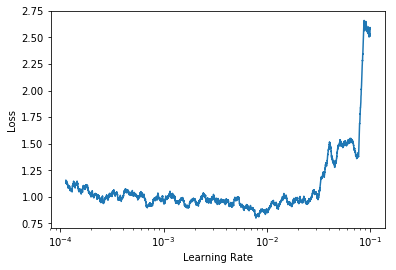

In [52]:
learner.plot_lrs(200)

In [53]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-4,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [54]:
del cfobj
torch.cuda.empty_cache()

In [55]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts)
cfobj=cfobj.to(device)

In [56]:
learner.run_epochs(dltrain,dlvalid,25)

Epoch:0 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:2.5140842278901756                 Valid Loss:1.5394107315107342 Train RMSE:1.530562494258547 Valid RMSE:1.189806990612655
Epoch:1 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:1.1140191104185566                 Valid Loss:1.0237045057478356 Train RMSE:1.009944003516014 Valid RMSE:0.9785044914956126
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.9181965080839259                 Valid Loss:0.9479365295226095 Train RMSE:0.919725260157683 Valid RMSE:0.9419140479393829
Epoch:3 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.8463828397309867                 Valid Loss:0.899710833577293 Train RMSE:0.882409006756563 Valid RMSE:0.911827467383918
Epoch:4 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.8066605357341573                 Valid Loss:0.8807632071952041 Train RMSE:0.8600690510475666 Valid RMSE:0.9062531715559631
Epoch:5 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.7881774852040508          

KeyboardInterrupt: 

In [64]:
del cfobj
torch.cuda.empty_cache()

In [65]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts)
cfobj=cfobj.to(device)

In [66]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=3e-4,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [67]:
learner.run_epochs(dltrain,dlvalid,5)

Epoch:0 Learning rate 0.0003 Weight Decay 1e-07 Train Loss:0.9428404931337618                 Valid Loss:1.0055351509734054 Train RMSE:0.9349908656395449 Valid RMSE:0.9678790197265386
Epoch:1 Learning rate 0.0003 Weight Decay 1e-07 Train Loss:0.8714152783610594                 Valid Loss:0.9628231429526676 Train RMSE:0.8969183986049687 Valid RMSE:0.9446646202131003
Epoch:2 Learning rate 0.0003 Weight Decay 1e-07 Train Loss:0.8329968650454894                 Valid Loss:0.933381544507325 Train RMSE:0.8755859113438804 Valid RMSE:0.9302675853126169
Epoch:3 Learning rate 0.0003 Weight Decay 1e-07 Train Loss:0.810503990710575                 Valid Loss:0.9208100599950972 Train RMSE:0.862384259384994 Valid RMSE:0.9227851890294582
Epoch:4 Learning rate 0.0003 Weight Decay 1e-07 Train Loss:0.7931904967989883                 Valid Loss:0.9180609327486164 Train RMSE:0.8537275484448881 Valid RMSE:0.9238546200873224


In [58]:
del cfobj
torch.cuda.empty_cache()

In [59]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts)
cfobj=cfobj.to(device)

In [153]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=8e-3,end_lr=8e-4)

In [154]:
learner.run_epochs(dltrain,dlvalid,20)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.843544218016326                 Valid Loss:0.8981637894800029 Train RMSE:0.8810616715046327 Valid RMSE:0.9123333699528205
Epoch:1 Learning rate 0.002 Weight Decay 1e-07 Train Loss:0.7616456080574874                 Valid Loss:0.8694652731838347 Train RMSE:0.8347994758886323 Valid RMSE:0.8977518560149601
Epoch:2 Learning rate 0.0008 Weight Decay 1e-07 Train Loss:0.7314371012308213                 Valid Loss:0.869653258245205 Train RMSE:0.817331555922132 Valid RMSE:0.8966047095573153
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.7710638780406924                 Valid Loss:0.8848729260283552 Train RMSE:0.8408356648867297 Valid RMSE:0.9043134218701291
Epoch:4 Learning rate 0.0031622776601683794 Weight Decay 1e-07 Train Loss:0.7464543257075479                 Valid Loss:0.9129999140713254 Train RMSE:0.8266364040472902 Valid RMSE:0.9187421742830725
Epoch:5 Learning rate 0.002 Weight Decay 1e-07 Train Loss:0.72386207182

In [172]:

torch.save(cfobj,f'{DATAPATH}/inter/cfobj')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [177]:
torch.save(optimizer,f'{DATAPATH}/inter/optimizer')

In [183]:
pickle.dump(learner,open(f'{DATAPATH}/inter/learner','wb'))

PicklingError: Can't pickle <class '__main__.Learner'>: it's not the same object as __main__.Learner